In [2]:
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2, get_perms
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector
from scipy.linalg import expm

Lx, Ly = (4, 4)
L = Lx*Ly
latt = qib.lattice.TriangularLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
perms_1 = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1, 2, 3, 0, 5, 6, 7, 4, 9, 10, 11, 8, 13, 14, 15, 12]]
perms_2 = [[0, 5, 10, 15, 3, 4, 9, 14, 2, 7, 8, 13, 1, 6, 11, 12], [5, 10, 15, 0, 4, 9, 14, 3, 7, 8, 13, 2, 6, 11, 12, 1]]
perms_3 = [[0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15], [4, 8, 12, 0, 5, 9, 13, 1, 6, 10, 14, 2, 7, 11, 15, 3]]

J, h, g = (1, 0, 3)
Es = []
"""for g in np.linspace(10, 10, 30):
    hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=20)
    idx = eigenvalues.argsort()
    eigenvalues_sort = eigenvalues[idx]
    Es.append(eigenvalues_sort[0])"""

'for g in np.linspace(10, 10, 30):\n    hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()\n    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=20)\n    idx = eigenvalues.argsort()\n    eigenvalues_sort = eigenvalues[idx]\n    Es.append(eigenvalues_sort[0])'

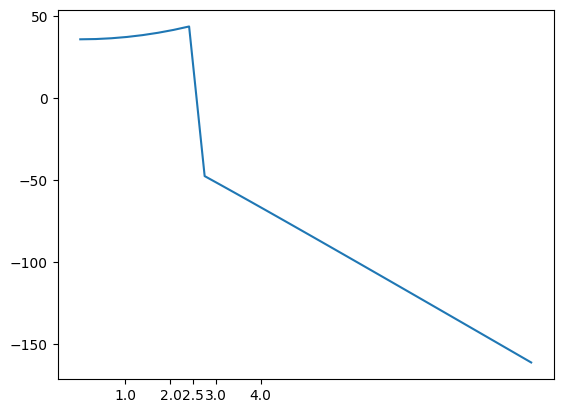

In [40]:
plt.plot(np.linspace(0, 10, 30), Es)
plt.xticks([1, 2, 2.5, 3, 4])
plt.show()

In [3]:
"""
    Now here is to compare the performance of the ccU circuit
    with the 1st and 2nd order Trotter circuits, in terms of 
    gate count vs Trotter error. I demonstrate it on L=10 system.
"""

from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
from scipy import sparse as sp


def controlled_trotter(c1, c2, L, Lx, Ly, J, g, perms_1, perms_2, perms_3, dt=0.1, dag=False):
    nsteps = int(np.ceil(c1/(2 * dt)))
    t = c1/(2*nsteps)

    #indices = [0, 1]
    #coeffs = [1, 1]
    indices = oc.SplittingMethod.suzuki(2, 1).indices
    coeffs = oc.SplittingMethod.suzuki(2, 1).coeffs
    perms_ext = [perms_1, perms_2, perms_3]*len(indices)
    
    hloc1 = g*(np.kron(X, I2)+np.kron(I2, X))/6
    hloc2 = J*np.kron(Z, Z)
    hlocs = (hloc1, hloc2)

    K = []
    for i, perms in enumerate(perms_ext):
        perm = perms[0]
        K_layer = [None for _ in range(L)]
        for j in range(len(perm)//2):
            K_layer[perm[2*j]] = CYGate
            K_layer[perm[2*j+1]] = CZGate
        K.append(K_layer)

    Vlist_start = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hlocs[i]))
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)


    qc = qiskit.QuantumCircuit(L+1)
    if dag:
        qc.x(L)
    for n in range(nsteps):
        for layer, qc_gate in enumerate(Vlist_gates):

            perms = perms_1
            qc.x(L)
            for j in range(L):
                if K[3*layer][j]:
                    qc.append(K[3*layer][j](), [L, L-1-j])
            qc.x(L)
            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])
            qc.x(L)
            for j in range(L):
                if K[3*layer][j]:
                    qc.append(K[3*layer][j](), [L, L-1-j])
            qc.x(L)

            perms = perms_2
            qc.x(L)
            for j in range(L):
                if K[3*layer+1][j]:
                    qc.append(K[3*layer+1][j](), [L, L-1-j])
            qc.x(L)
            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])

            qc.x(L)
            for j in range(L):
                if K[3*layer+1][j]:
                    qc.append(K[3*layer+1][j](), [L, L-1-j])
            qc.x(L)

            perms = perms_3
            qc.x(L)
            for j in range(L):
                if K[3*layer+2][j]:
                    qc.append(K[3*layer+2][j](), [L, L-1-j])
            qc.x(L)
            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])
            qc.x(L)
            for j in range(L):
                if K[3*layer+2][j]:
                    qc.append(K[3*layer+2][j](), [L, L-1-j])
            qc.x(L)
    qc.cp(-c2, L, 0)
    qc.x(0)
    qc.cp(-c2, L, 0)
    qc.x(0)
    if dag:
        qc.x(L)
    return qc


In [223]:
import sys
sys.path.append("../../../AQC-F/src/qetu")
from qetu import qetu_rqc_oneLayer

def run_qetu(Lx, Ly, g, c1, c2, perms1, perms2, perms3, mu=0.95, d=12, M=1, return_circ=False, qc_init=None, 
             full_measure=False, return_one_layer=False, a_assess=None, reverse=False, dt=0.1,
             return_poly=False, state=None):
    t = c1/2
    print("QETU t: ", c1/2)
    qc_cU = controlled_trotter(c1, c2, L, Lx, Ly, J, g, perms1, perms2, perms3, dag=False, dt=dt)
    qc_cU_dag = controlled_trotter(c1, c2, L, Lx, Ly, J, g, perms1, perms2, perms3, dag=True, dt=dt)
    qc_cfUs = [qc_cU, qc_cU_dag]

    ket_0 = np.array([1,0])
    
    # QETU Circuit:
    c, phis_max_iter, = (0.95, 10)
    qc_qetu, _ = qetu_rqc_oneLayer(L, 0, 0, 1, mu, d=d, c2=0,
                                    qc_cU_custom=(qc_cfUs[0], qc_cfUs[1]),
                                       a_assess=a_assess, reverse=reverse
                                    )
    if return_one_layer:
        return qc_qetu
    
    qcs_qetu = []
    for m in range(M):
        qcs_qetu.append(qc_qetu)

    if return_circ:
        mid_cbits = len(qcs_qetu)
        qc = qiskit.QuantumCircuit(L+1, (L+1 if full_measure else 1) + mid_cbits)
        if qc_init is not None:
            qc.append(qc_init.to_gate(), [i for i in range(L)])
        
        for j, qc_qetu in enumerate(qcs_qetu):
            qc.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            qc.measure(L, j)
        return qc, mid_cbits
    else:
        backend = Aer.get_backend("statevector_simulator")
        qc_RQC = qiskit.QuantumCircuit(L+1, L+1)
        if state is not None:
            qc_RQC.initialize(np.kron(ket_0, state))
        if qc_init is not None:
            qc_RQC.append(qc_init.to_gate(), [i for i in range(L)])
        
        for qc_qetu in qcs_qetu:
            qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
            aR = sp.kron(np.array([[1,0],[0,0]]), sp.eye(2**L), format='csr') @ bR
            print("Success Prob: ", np.linalg.norm(aR)**2)
            aR = aR / np.linalg.norm(aR)
            qc_RQC.reset([i for i in range(L+1)])
            qc_RQC.initialize(aR)
        
        toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(10)]
        plt.plot([i for i in range(len(toPlot))], toPlot)
        plt.scatter([i for i in range(len(toPlot))], toPlot)
        #plt.show()
        print("State Fid: ", toPlot[0])
    
        mid_cbits = len(qcs_qetu)
        qc = qiskit.QuantumCircuit(L+1, 1 + mid_cbits)
        qc.initialize(np.kron(ket_0, state))
        if qc_init is not None:
            qc.append(qc_init.to_gate(), [i for i in range(L)])
        for j, qc_qetu in enumerate(qcs_qetu):
            qc.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            qc.measure(L, j)
            
        noise_model = NoiseModel()
        tr = transpile(qc, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx'])
        dag = circuit_to_dag(tr)
        count_ops = dag.count_ops()

        counts_q = {}
        for i in range(L+1):
            counts_q[i] = {"s": 0, "d": 0}
        
        for gate in tr.data:
            if len(gate.qubits) == 1:
                counts_q[gate.qubits[0].index]["s"] += 1
            elif len(gate.qubits) == 2:
                counts_q[gate.qubits[0].index]["d"] += 1
                counts_q[gate.qubits[1].index]["d"] += 1
        counts_q["gates"] = count_ops['unitary'] + count_ops['cx']
        
        if return_poly:
            return toPlot, counts_q, aR[:2**L], phis_[2]
        return toPlot, counts_q, aR[:2**L]

In [224]:
"""
    Adiabatic Evolution Implementation.
"""
from qiskit import Aer, transpile, execute
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
X = np.array([[0.,  1.], [1.,  0.]])
Z = np.array([[1.,  0.], [0., -1.]])


def trotter(Lx, Ly, tau, L, J_i, h_i, g_i, J_f, h_f, g_f, lamb, perms):
    L = Lx * Ly
    assert lamb <= 1 and lamb >= 0
    J = lamb*J_f + (1-lamb)*J_i
    g = lamb*g_f + (1-lamb)*g_i
    h = lamb*h_f + (1-lamb)*h_i
    perms1, perms2, perms3 = perms

    qc = qiskit.QuantumCircuit(L)
    hloc1 = J*np.kron(Z, Z)
    hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/6
    hlocs = (hloc2, hloc1)
        
    perms = perms1+perms2+perms3
    perm_set = perms
    
    indices = [0 , 1,  0]
    coeffs  = [.5, 1, .5]

    Vlist_start = []
    perms = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*tau*hlocs[i]))
        perms.append(perm_set[i])
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1])
        Vlist_gates.append(qc2)
    
    for layer, qc_gate in enumerate(Vlist_gates):
        for perm in perms:
            for j in range(len(perm)//2):
                qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])
    return qc


def construct_ising_local_term_(J, g, ndim, h=0):
    X = np.array([[0.,  1.], [1.,  0.]])
    Z = np.array([[1.,  0.], [0., -1.]])
    I = np.identity(2)
    return J*np.kron(Z, Z) + g*(0.5/ndim)*(np.kron(X, I) + np.kron(I, X)) + h*(0.5/ndim)*(np.kron(Z, I) + np.kron(I, Z))


def run_adiabatic(Lx, Ly, g, T, S, perms, state=None, return_state=False, h_i=0, h_f=0):
    L = Lx*Ly
    tau = 1/S
    t_s = np.linspace(0, T, S*T)
    sch = lambda t, T: np.sin(np.pi*t/(2*T))**2
    
    qc = qiskit.QuantumCircuit(L)
    if state is not None:
        pass
    else:
        qc.x([i for i in range(L)])
        qc.h([i for i in range(L)])
    for s in range(S*T):
        qc.append(trotter(Lx, Ly, tau, L, J, h_i, 0, J, h_f, g, sch(t_s[s], T), perms).to_gate(), [i for i in range(L)])
    
    backend = Aer.get_backend("statevector_simulator")
    qc_ = qiskit.QuantumCircuit(L)
    if state is not None:
        qc_.initialize(state)
    qc_.append(qc.to_gate(), [i for i in range(L)])
    final = execute(transpile(qc_), backend).result().get_statevector().data
    print("AQC: ", [np.linalg.norm(np.vdot(final, eigenvectors_sort[:, i]))**2 for i in range(20)])

    
    if return_state:
        return qc
    else:
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc_, basis_gates=['unitary', 'u3', 'initialize']))
        count_ops = dag.count_ops()
        print(count_ops)
        #return [state_fidelity(final, eigenvectors_sort[:, i]) for i in range(10)], {"gates": count_ops}, final


In [218]:
J = 1
g = 2.5 # somewhere 2.7-2.8 is the PT point.
Lx, Ly = (4, 4)
L = Lx*Ly
latt = qib.lattice.TriangularLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)

"""H_i = qib.IsingHamiltonian(field, J, 0, 1e-6).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H_i, k=20)
#eigenvalues, eigenvectors = np.linalg.eig(H_i.toarray())
idx = eigenvalues.argsort()
eigenvectors_sort = eigenvectors[:,idx]
eigenvalues_sort = eigenvalues[idx]
state = eigenvectors_sort[:, 0]"""


hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=100)
#eigenvalues, eigenvectors = np.linalg.eig(hamil.toarray())
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
eigenvalues_sort

array([-43.54184379, -39.9200887 , -39.9200887 , -39.9200887 ,
       -39.91813547, -39.91813547, -39.91813547, -39.91813547,
       -39.91813547, -39.91813547,  36.99699884,  36.99699884,
        36.99699884,  36.99699884,  37.01045377,  37.01045377,
        37.01045377,  37.01045377,  37.01045377,  37.01045377,
        37.01478564,  37.01478564,  37.01478564,  37.01478564,
        37.01478564,  37.01478564,  37.51240402,  37.51240402,
        37.51240402,  37.5478799 ,  37.5478799 ,  37.5478799 ,
        37.5568465 ,  37.5568465 ,  38.10404524,  38.10404524,
        38.10404524,  38.1045052 ,  38.1045052 ,  38.1045052 ,
        38.1045052 ,  38.1045052 ,  38.1045052 ,  38.33841364,
        38.33841364,  38.33841364,  38.33841364,  38.33841364,
        38.33841364,  38.50845349,  38.50845349,  38.50845349,
        38.8451185 ,  38.8451185 ,  38.8451185 ,  38.8451185 ,
        38.8451185 ,  38.8451185 ,  39.15842539,  40.01369271,
        40.01369271,  40.01369271,  40.01369271,  40.01

In [219]:
state = psi.data

AQC:  [0.11222010035860364, 6.330774349234854e-31, 2.853793714869819e-31, 6.264579452908553e-30, 2.9291318824979893e-31, 1.0179411032499371e-30, 2.419011738540219e-31, 5.81018645747037e-31, 1.8527131032519186e-31, 3.9289017885273644e-32, 1.35376541596418e-34, 1.3700519636632195e-32, 5.800668810319547e-33, 2.3887657105337447e-32, 4.9370136489920675e-31, 3.315219240443647e-31, 5.432782241195366e-34, 9.785990470595544e-35, 5.81599299548725e-31, 2.0781456721479238e-32]
QETU t:  0.16325465704222833
Constructing QETU sequence
Success Prob:  0.3219640497868274
State Fid:  0.26996139140352404

 AQC+F:  0.26996139140352404 


 CXs:  4040 



/tmp/ipykernel_42029/4223365128.py:84: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  counts_q[gate.qubits[0].index]["d"] += 1
/tmp/ipykernel_42029/4223365128.py:85: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  counts_q[gate.qubits[1].index]["d"] += 1
/tmp/ipykernel_42029/4223365128.py:82: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.

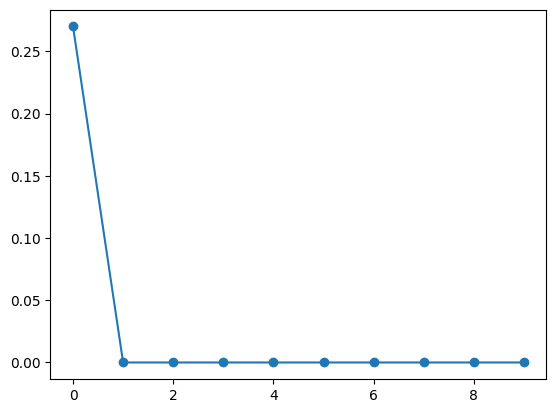

In [229]:
spectrum_upper_bound = eigenvalues_sort[1].real + 5
spectrum_lower_bound = eigenvalues_sort[0].real - 1
max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound
c1 = (np.pi) / (max_spectrum_length)
c2 = - c1 * spectrum_lower_bound
eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

qc_A = run_adiabatic(Lx, Ly, g, 2, 4, (perms_1, perms_2, perms_3), state=state, return_state=True)
fid, gates, final = run_qetu(Lx, Ly, g, c1, c2, perms_1, perms_2, perms_3, mu=0.8, d=4, M=1, qc_init=qc_A, state=state, dt=0.05)
print('\n AQC+F: ', fid[0], '\n')
print('\n CXs: ', gates['gates'], '\n')

In [221]:
np.sum(np.array([np.abs(np.vdot(state, eigenvectors_sort[:, i]))**2 for i in range(7)]))

0.006465099905567391

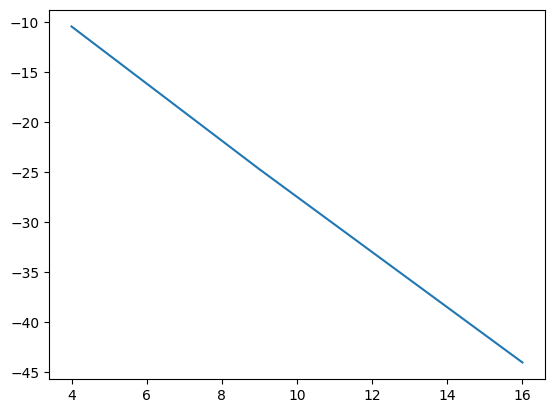

In [171]:
plt.plot([4, 9, 16], [-10.42, -24.6883855, -44])

In [184]:
9.8 + 9

18.8

In [ ]:
H_i = qib.IsingHamiltonian(field, J, 0, 1e-6).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H_i, k=1000)
#eigenvalues, eigenvectors = np.linalg.eig(H_i.toarray())
idx = eigenvalues.argsort()
eigenvectors_sort_i = eigenvectors[:,idx]
eigenvalues_sort_i = eigenvalues[idx]
state = eigenvectors_sort_i[:, 0]

eigenvalues_sort_i

In [199]:
def eval_energy(config):
    e = 0
    for perm in perms_1+perms_2+perms_3:
        for j in range(len(perm)//2):
            e += 1 if config[perm[2*j]]==config[perm[2*j+1]] else -1
    return e

In [211]:
from itertools import product

e = 48
gs = '0'*L
gss = []
bitstrings = [''.join(bits) for bits in product('01', repeat=16)]
for bitstring in bitstrings:
    if eval_energy(bitstring) < e:
        gs = bitstring
        e = eval_energy(bitstring)
    if eval_energy(bitstring) == -16:
        gss.append(bitstring)
e

-16

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np


ground_states = gss
n = len(ground_states[0])
dim = 2**n

state = np.zeros(dim, dtype=complex)
for s in ground_states:
    index = int(s, 2)
    state[index] = 1 / np.sqrt(len(ground_states))
psi = Statevector(state)


qc = QuantumCircuit(n)
qc.initialize(psi.data, qc.qubits)
qc.draw('mpl')

In [231]:
J = 1
g = 1 # somewhere 2.7-2.8 is the PT point.
Lx, Ly = (4, 4)
L = Lx*Ly
latt = qib.lattice.TriangularLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)

hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=100)
#eigenvalues, eigenvectors = np.linalg.eig(hamil.toarray())
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
eigenvalues_sort

array([29.26722374, 29.26722374, 29.2672392 , 29.2672392 , 29.34864237,
       29.34864237, 29.34864237, 29.34864237, 29.34864237, 29.34864237,
       29.3486453 , 29.3486453 , 29.3486453 , 29.3486453 , 29.3486453 ,
       29.3486453 , 29.48158738, 29.48158738, 29.48158738, 29.48158738,
       29.48158738, 29.48158738, 29.48159502, 29.48159502, 29.48159502,
       29.48159502, 29.48159502, 29.48159502, 29.49070957, 29.49070957,
       29.49070957, 29.49071087, 29.49071087, 29.49071087, 29.71541535,
       29.71541535, 29.71541535, 29.71541535, 29.71541535, 29.71541535,
       29.71544444, 29.71544444, 29.71544444, 29.71544444, 29.71544444,
       29.71544444, 29.7157834 , 29.7157834 , 29.7157834 , 29.71582576,
       29.71582576, 29.71582576, 29.86615804, 29.86615804, 29.86615804,
       29.86615804, 29.86615804, 29.86615804, 29.86635142, 29.86635142,
       29.86635142, 29.86635142, 29.86635142, 29.86635142, 29.96668721,
       29.96747398, 37.33461583, 37.33461583, 37.33461583, 37.33

AQC:  [3.597444303924867e-33, 8.17804741607482e-35, 8.520856573114442e-33, 5.317365370275304e-36, 1.359177774359678e-33, 9.072088125915945e-33, 3.386037839494732e-35, 8.795266505442225e-33, 4.7172276993248935e-33, 4.6809324251014136e-34, 6.251156916971967e-34, 1.825860313418879e-32, 1.5199993914923975e-34, 1.1235436191608762e-33, 2.646474941796919e-35, 3.1763927548838814e-33, 2.8486922746048353e-35, 1.3991515015131134e-33, 2.0421928365947598e-34, 8.175214112163647e-33]
QETU t:  0.2617993877991485
Constructing QETU sequence
Success Prob:  0.3940244126786867
State Fid:  5.570707382883129e-33

 AQC+F:  5.570707382883129e-33 


 CXs:  5192 



/tmp/ipykernel_42029/4223365128.py:82: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  counts_q[gate.qubits[0].index]["s"] += 1
/tmp/ipykernel_42029/4223365128.py:84: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  counts_q[gate.qubits[0].index]["d"] += 1
/tmp/ipykernel_42029/4223365128.py:85: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.

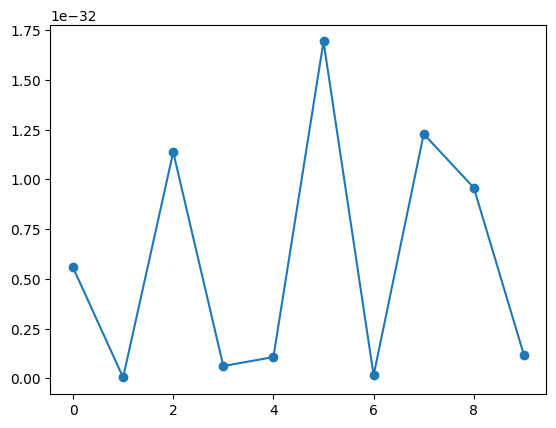

In [233]:
spectrum_upper_bound = eigenvalues_sort[1].real + 5
spectrum_lower_bound = eigenvalues_sort[0].real - 1
max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound
c1 = (np.pi) / (max_spectrum_length)
c2 = - c1 * spectrum_lower_bound
eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

qc_A = run_adiabatic(Lx, Ly, g, 0, 4, (perms_1, perms_2, perms_3), state=state, return_state=True)
fid, gates, final = run_qetu(Lx, Ly, g, c1, c2, perms_1, perms_2, perms_3, mu=0.8, d=4, M=1, qc_init=qc_A, state=state, dt=0.05)
print('\n AQC+F: ', fid[0], '\n')
print('\n CXs: ', gates['gates'], '\n')